In [ ]:
pip install -r requirements.txt --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests
import zipfile

CSV_LINK = "https://cdn.stackoverflow.co/files/jo7n4k8s/production/49915bfd46d0902c3564fd9a06b509d08a20488c.zip/"
RESULTS_FILENAME = "stackoverflow_results.zip"
CSV_FILENAME = "survey_results_public.csv"

In [ ]:
response = requests.get(CSV_LINK)
if not response.ok:
    raise ValueError(f"Cannot get zip containing results from {CSV_LINK}. Check if the link is correct")

with open(RESULTS_FILENAME, mode="wb") as file:
    file.write(response.content)


In [ ]:
if not os.path.isfile(RESULTS_FILENAME):
    raise OSError(f"{RESULTS_FILENAME} zip file is not present.")

if not zipfile.is_zipfile:
    raise OSError(f"{RESULTS_FILENAME} zip file is corrupted.")

try:
    with zipfile.ZipFile(RESULTS_FILENAME) as archive:
        archive.printdir()
        archive.extract(CSV_FILENAME)
except zipfile.BadZipFile as error:
    print(error)

In [ ]:
df = pd.read_csv(CSV_FILENAME)
df.set_index("ResponseId", inplace=True)

df.info()

In [ ]:
filtered = df[df["ConvertedCompYearly"].isna() == False]
q_hi = filtered["ConvertedCompYearly"].quantile(0.99) #get the 99th percentile (outliers, probably data errors)
filtered = filtered[filtered["ConvertedCompYearly"] < q_hi]
grouped = filtered.groupby("Age")["ConvertedCompYearly"]

indexes = list(grouped.mean().index)
indexes.insert(0, indexes.pop())


bar_width = 0.33
x = np.arange(len(grouped.mean().index))

adjusted_x = x * 1.25
fig, ax = plt.subplots(layout='constrained')

bar = ax.bar(adjusted_x, grouped.mean().reindex(indexes), bar_width, color="blue", label="mean")
max_bar = ax.bar(adjusted_x + bar_width, grouped.max().reindex(indexes), bar_width, color="green", label="max")

q75 = grouped.quantile(0.75).reindex(indexes)
q25 = grouped.quantile(0.25).reindex(indexes)
bar_height = q75 - q25
box_bar = ax.bar(adjusted_x + bar_width * 2, bar_height, bar_width, bottom=q25, color="red", label="75th-25th percentile range")

ax.legend(ncols=2, loc="upper right")
ax.set_xticks(adjusted_x + bar_width, indexes)
ax.set_ylabel('ConvertedCompYearly')
plt.xticks(rotation=30, ha="right")

In [ ]:
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
import random

custom_order = [
    'Primary/elementary school', 
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)', 
    'Some college/university study without earning a degree',
    'Associate degree (A.A., A.S., etc.)',
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
    'Professional degree (JD, MD, Ph.D, Ed.D, etc.)',
    'Something else'
]

non_na_dev_types_and_ed_levels = df.dropna(subset=["DevType", "EdLevel"])
non_na_dev_types_and_ed_levels.loc[:, 'EdLevel'] = pd.Categorical(non_na_dev_types_and_ed_levels['EdLevel'], categories=custom_order, ordered=True)

grouped_ed_levels = non_na_dev_types_and_ed_levels.groupby("EdLevel", observed=True)

bar_width = 0.2
x = np.arange(len(grouped_ed_levels))
adjusted_x = x * 1.2

job_types = {
    "Developer, full-stack": (0.596078431372, 0.9254901960, 0.333333333, 1),
    "Developer, back-end": (0.9372549019, 0.01568627450, 0.2588235294, 1),
    "Other (please specify):": (0.333333333, 0.01568627450, 0.46666666, 1),
    "Student": (0.262745098, 0.8078431372, 0.19607843137, 1),
    "Developer, front-end": (0.1058823529, 0.117647058823, 0.79215686, 1),
    "Academic researcher": (0.803921568, 0.5137254901, 0.79215686274, 1),
    "Developer, desktop or enterprise applications": (0.3721208613689483, 0.6760034780790405, 0.18707464066071333, 1),
}

fig, ax = plt.subplots(figsize=(14, 8))

for i, (education_level, group) in enumerate(grouped_ed_levels):
    top_jobs = group['DevType'].value_counts().nlargest(3)
    for j, (job, count) in enumerate(top_jobs.items()):
        label = job
        color = job_types.get(job, to_rgba((random.random(), random.random(), random.random())))
        ax.bar(adjusted_x[i] + j * bar_width, count, bar_width, color=color, label=label)

ax.set_xlabel('Education')
ax.set_ylabel('Number of workers in each position')
ax.set_title('Top 3 Most Popular Job Positions for Each Education Level')
plt.legend(handles=[Patch(color=value, label=key) for key, value in job_types.items()], loc='upper left', bbox_to_anchor=(1,1))

indexes = [education_level[:60] + ('...' if len(education_level) > 60 else '') for education_level, _ in grouped_ed_levels]
ax.set_xticks(adjusted_x + bar_width)
ax.set_xticklabels(indexes, rotation=30, ha="right")

plt.show()


In [ ]:
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')
non_na_dev_types = df[df["DevType"].isna() == False]
non_na_dev_types_and_years_code = non_na_dev_types[non_na_dev_types['YearsCodePro'].isna() == False]
q_hi = non_na_dev_types_and_years_code["YearsCodePro"].quantile(0.99) #get the 99th percentile (outliers, probably data errors)
non_na_dev_types_and_years_code = non_na_dev_types_and_years_code[non_na_dev_types_and_years_code["YearsCodePro"] < q_hi]
grouped = non_na_dev_types_and_years_code.groupby("DevType")["YearsCodePro"]

indexes = grouped.mean().index
bar_width = 0.33
x = np.arange(len(grouped.mean().index))
adjusted_x = x * 1.5
fig, ax = plt.subplots(layout='constrained', figsize=(22, 8))

def custom_mode(series):
    counts = np.bincount(series)
    mode_value = np.argmax(counts)
    return mode_value

agg_functions = {
    'mean': 'mean',
    'median': 'median',
    'mode': custom_mode,
    'skewness': lambda x: x.skew(),
}

mode_values = grouped.agg(agg_functions['mode'])
median_values = grouped.agg(agg_functions['median'])
mean_values = grouped.agg(agg_functions['mean'])
skewness_values = grouped.agg(agg_functions['skewness'])

ax.bar(adjusted_x, mode_values, bar_width, color="purple", label="mode")
ax.bar(adjusted_x + bar_width, median_values, bar_width, color="green", label="median")
ax.bar(adjusted_x + bar_width * 2, mean_values, bar_width, color="blue", label="mean")
ax.bar(adjusted_x + bar_width * 3, skewness_values, bar_width, color="orange", label="skewness")

ax.legend(ncols=2, loc="upper left")
ax.set_xticks(adjusted_x + bar_width * 1.5, indexes)
ax.set_ylabel('Years of professional experience')
plt.xticks(rotation=30, ha="right")

In [ ]:
THRESHOLD = 0.05

programming_langs = df["LanguageHaveWorkedWith"].str.split(";", expand=True).stack().value_counts()

langs_sum = programming_langs.sum()
langs_filter = langs_sum * THRESHOLD

filtered_langs = programming_langs[programming_langs > langs_filter]

langs_others = programming_langs[programming_langs <= langs_filter].sum()

pie_values = pd.concat([filtered_langs, pd.Series([langs_others], index=["Others"])])

pie_values = pie_values.sort_values(ascending=False)

fig, ax = plt.subplots()
ax.pie(pie_values, labels=pie_values.index, autopct='%1.1f%%')
ax.set_title("Programming languages used by developers")

In [ ]:
THRESHOLD = 0.05

langs_by_age = list(df.groupby("Age")["LanguageHaveWorkedWith"])
langs_by_age.insert(0, langs_by_age.pop())
for age, langs in langs_by_age:
    langs = langs.str.split(";", expand=True).stack().value_counts()
    langs_by_age_sum = langs.sum()
    langs_by_age_filter = langs_by_age_sum * THRESHOLD

    filtered_langs = langs[langs > langs_by_age_filter]

    langs_others = langs[langs <= langs_by_age_filter].sum()

    pie_by_age_values = pd.concat([filtered_langs, pd.Series([langs_others], index=["Others"])])

    pie_by_age_values = pie_by_age_values.sort_values(ascending=False)

    fig, ax = plt.subplots()
    ax.pie(pie_by_age_values, labels=pie_by_age_values.index, autopct='%1.1f%%')
    ax.set_title(f"Programming languages used by developers in age range {age}")


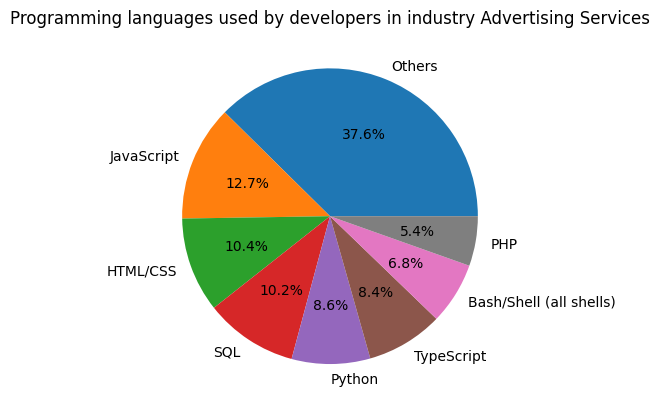

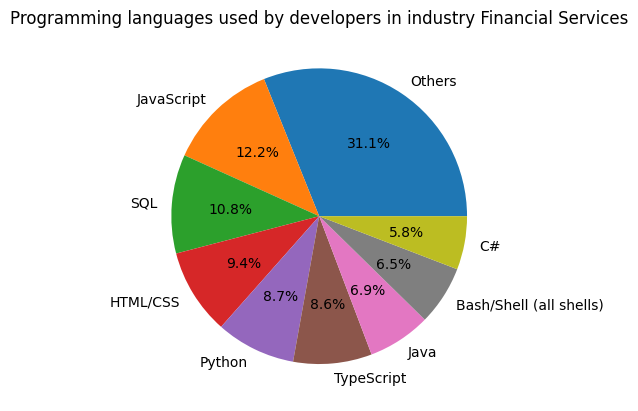

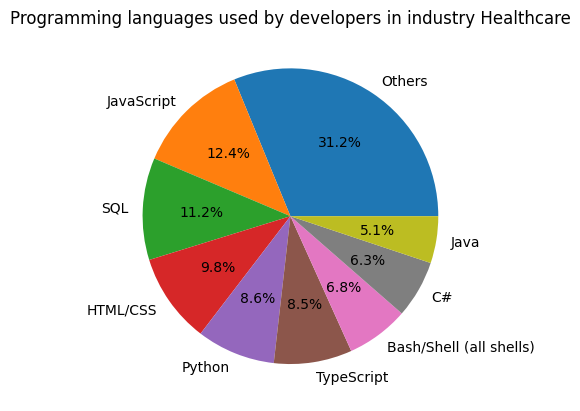

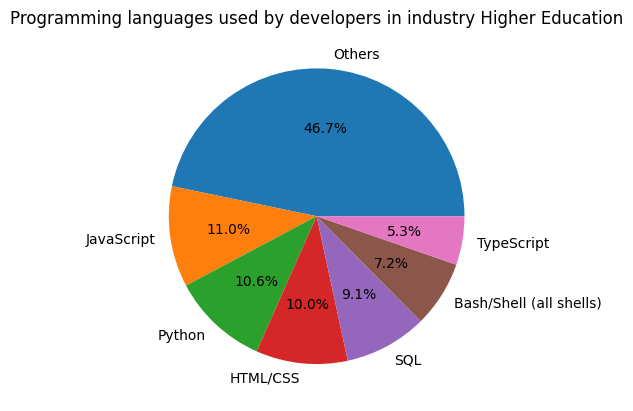

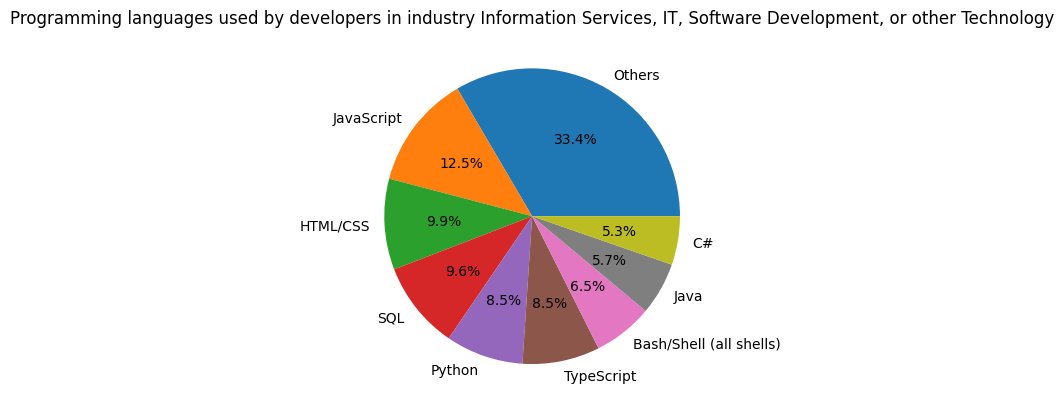

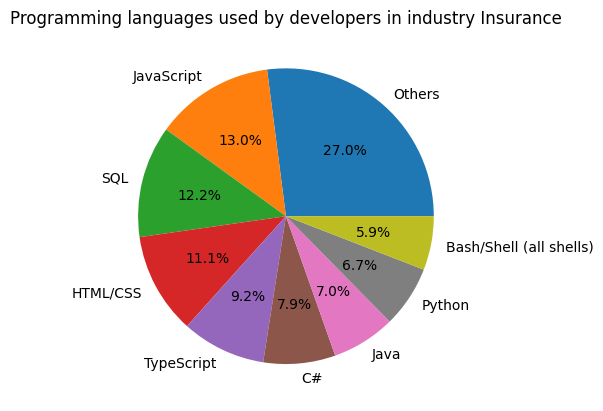

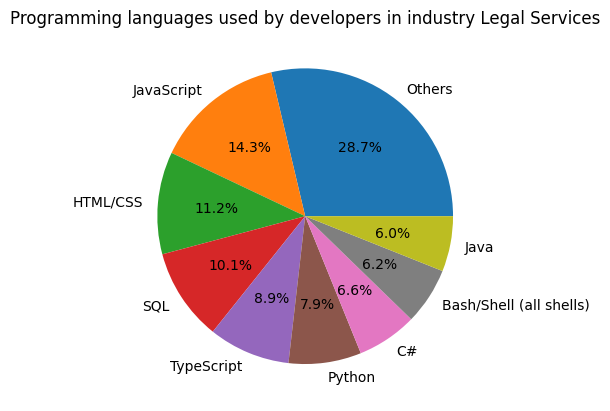

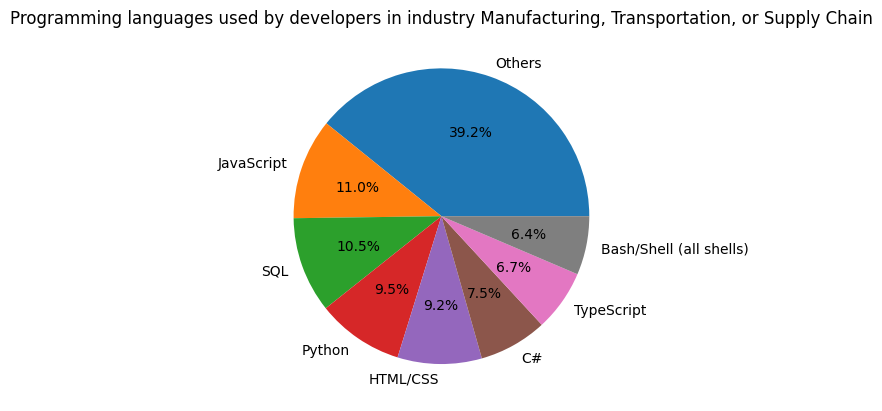

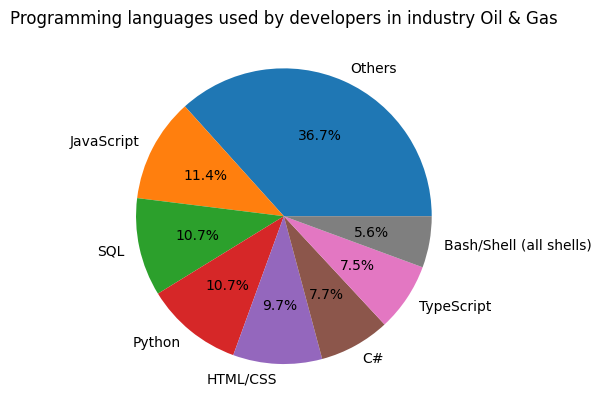

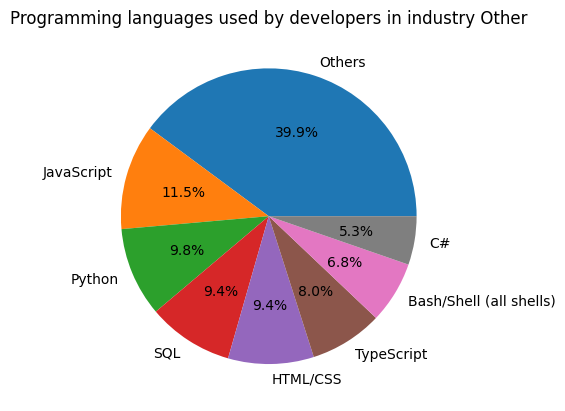

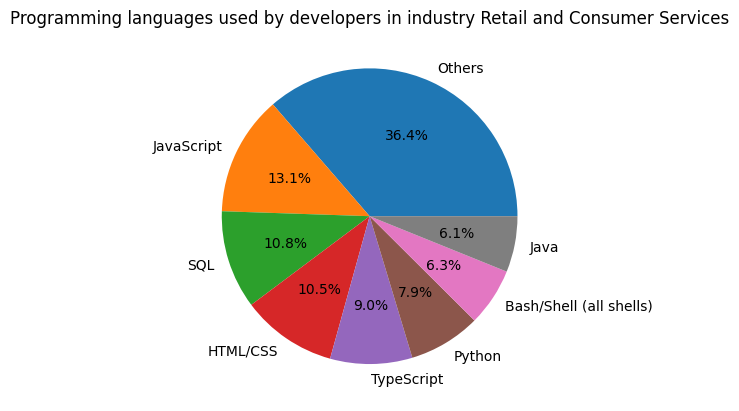

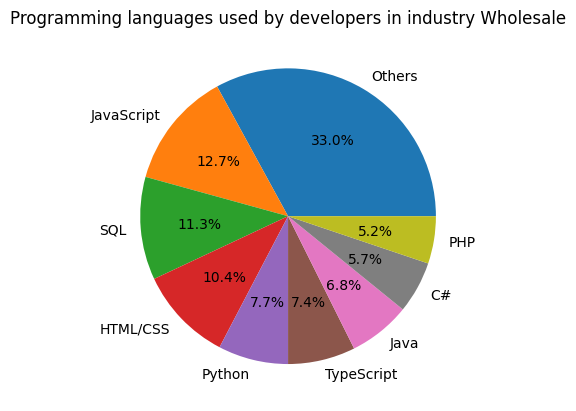

In [112]:
THRESHOLD = 0.05
series_languages = df["LanguageHaveWorkedWith"].str.split(";", expand=True).stack()
df_languages = df.copy()
index_list = series_languages.index.get_level_values(0).unique().to_list()
df_languages = df_languages.loc[index_list]
df_languages["Split_languages"] = series_languages.groupby(series_languages.index.get_level_values(0)).apply(lambda x: x.tolist())

langs_by_industry = df_languages.groupby("Industry")["Split_languages"]
for industry, langs in langs_by_industry:
    langs = langs.explode().value_counts()
    langs_sum = langs.sum()
    langs_filter = langs_sum * THRESHOLD
    
    filtered_langs = langs[langs > langs_filter]

    langs_others = langs[langs <= langs_filter].sum()
    
    pie_by_industry_values = pd.concat([filtered_langs, pd.Series([langs_others], index=["Others"])])
    pie_by_industry_values = pie_by_industry_values.sort_values(ascending=False)

    fig, ax = plt.subplots()
    ax.pie(pie_by_industry_values, labels=pie_by_industry_values.index, autopct='%1.1f%%')
    ax.set_title(f"Programming languages used by developers in industry {industry}")



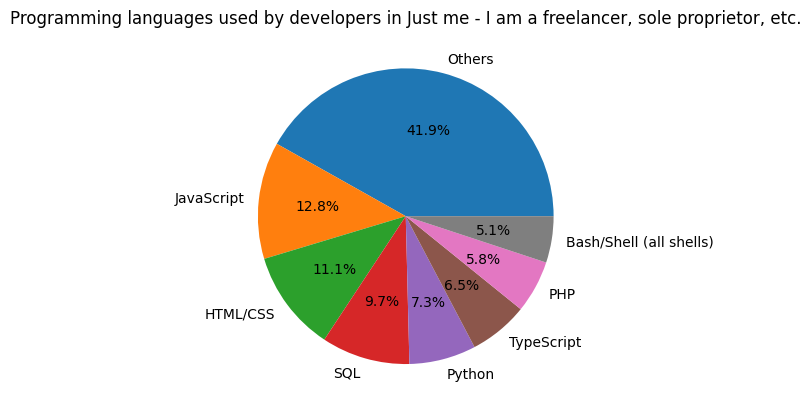

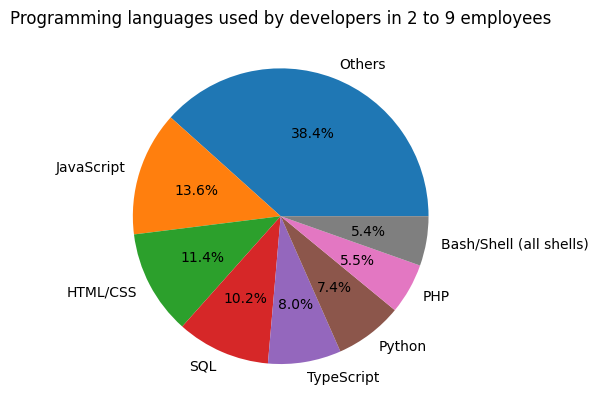

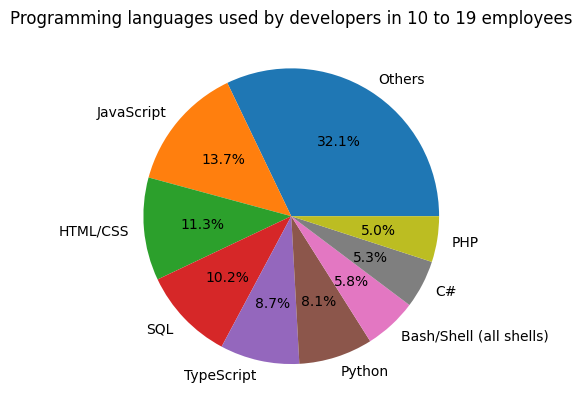

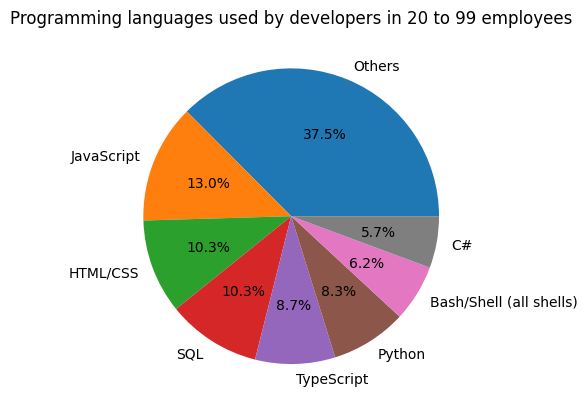

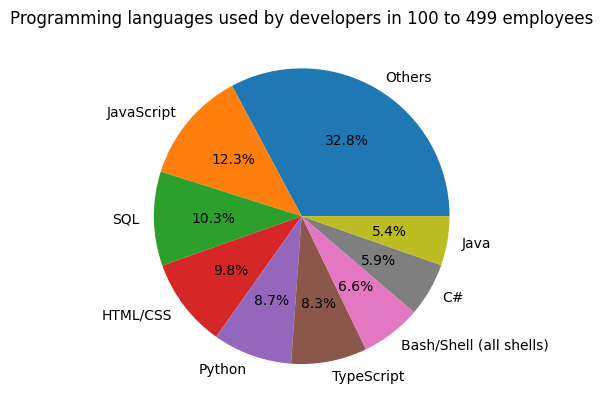

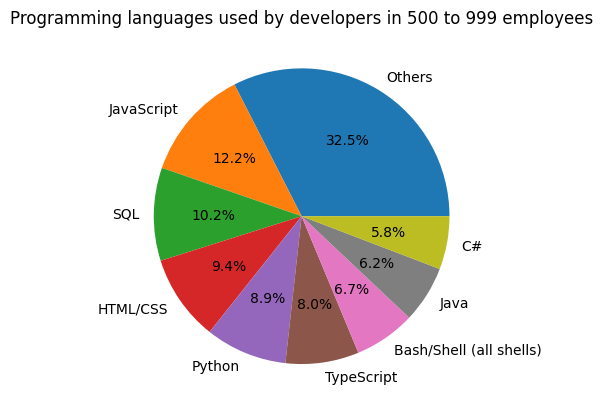

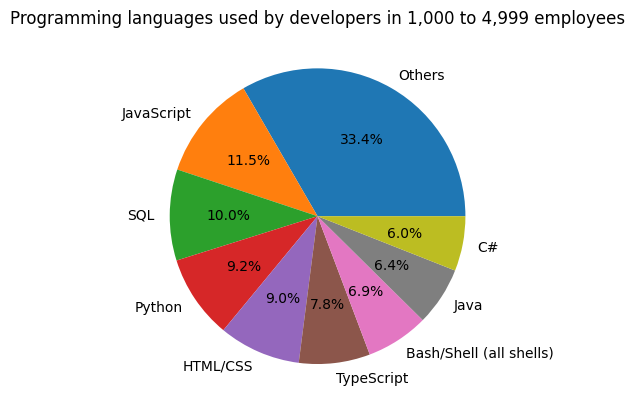

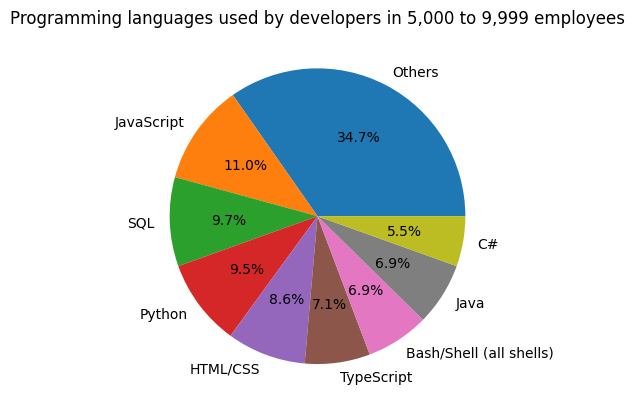

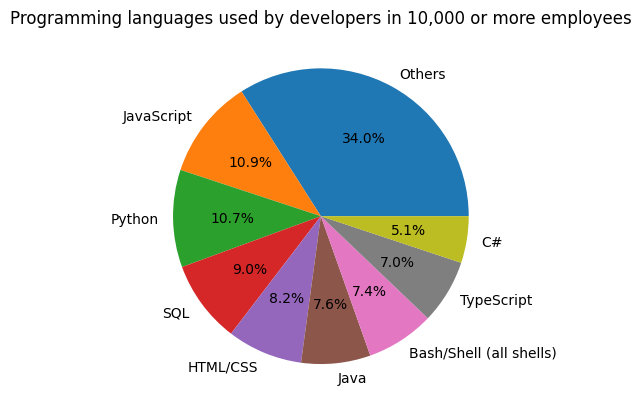

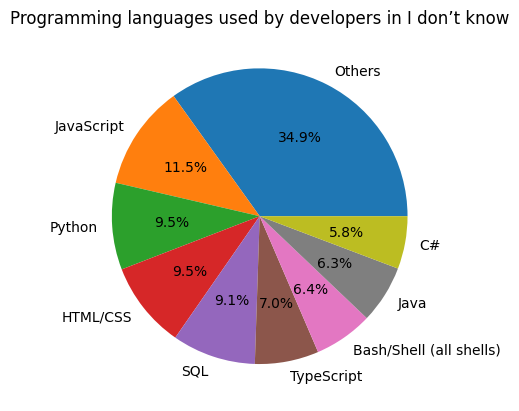

In [116]:
import re

def custom_sort(text):
    numeric_part = re.findall(r'\d+,?\d*', text)
    if numeric_part:
        return int(numeric_part[0].replace(',', '')) if numeric_part[0] else float('inf')
    return float('inf')

langs_by_org_size = df_languages.groupby("OrgSize")["Split_languages"]
langs_by_org_size = sorted(list(langs_by_org_size), key=lambda x: custom_sort(x[0]))
langs_by_org_size.insert(0, langs_by_org_size.pop())


for org_size, langs in langs_by_org_size:
    langs = langs.explode().value_counts()
    langs_sum = langs.sum()
    langs_filter = langs_sum * THRESHOLD

    filtered_langs = langs[langs > langs_filter]

    langs_others = langs[langs <= langs_filter].sum()

    pie_by_org_size_values = pd.concat([filtered_langs, pd.Series([langs_others], index=["Others"])])

    pie_by_org_size_values = pie_by_org_size_values.sort_values(ascending=False)

    fig, ax = plt.subplots()
    ax.pie(pie_by_org_size_values, labels=pie_by_org_size_values.index, autopct='%1.1f%%')
    ax.set_title(f"Programming languages used by developers in {org_size}")
    

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Just me - I am a freelancer, sole proprietor, etc.'),
  Text(1, 0, '2 to 9 employees'),
  Text(2, 0, '10 to 19 employees'),
  Text(3, 0, '20 to 99 employees'),
  Text(4, 0, '100 to 499 employees'),
  Text(5, 0, '500 to 999 employees'),
  Text(6, 0, '1,000 to 4,999 employees'),
  Text(7, 0, '5,000 to 9,999 employees'),
  Text(8, 0, '10,000 or more employees'),
  Text(9, 0, 'I don’t know')])

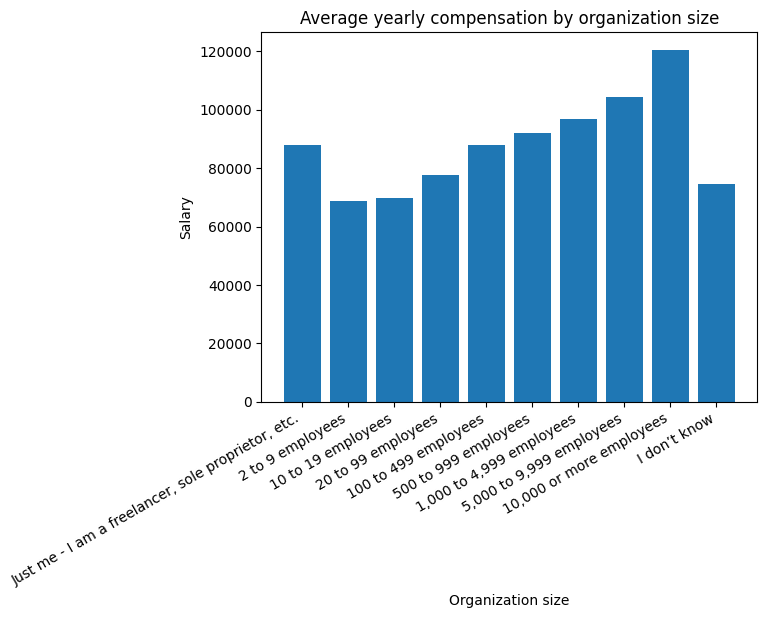

In [115]:
import re

def custom_sort(text):
    numeric_part = re.findall(r'\d+,?\d*', text)
    if numeric_part:
        return int(numeric_part[0].replace(',', '')) if numeric_part[0] else float('inf')
    return float('inf')


q_hi = df["ConvertedCompYearly"].quantile(0.99)
filtered_salaries = df[((df["ConvertedCompYearly"].isna() == False) & (df["ConvertedCompYearly"] > 0) & (df["ConvertedCompYearly"] < q_hi))] 

org_sizes = filtered_salaries.groupby(["OrgSize"])["ConvertedCompYearly"].mean()
org_sizes_sorted = sorted(org_sizes.index, key=custom_sort)
org_sizes_sorted.insert(0, org_sizes_sorted.pop())

average_salaries = [org_sizes[size] for size in org_sizes_sorted]

fig, ax = plt.subplots()
ax.bar(org_sizes_sorted, average_salaries)
ax.set_title("Average yearly compensation by organization size")
ax.set_ylabel("Salary")
ax.set_xlabel("Organization size")
plt.xticks(rotation=30, ha="right")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Advertising Services'),
  Text(1, 0, 'Healthcare'),
  Text(2, 0, 'Financial Services'),
  Text(3, 0, 'Retail and Consumer Services'),
  Text(4, 0, 'Other'),
  Text(5, 0, 'Insurance'),
  Text(6, 0, 'Oil & Gas'),
  Text(7, 0, 'Information Services, IT, Software Development, or other Technology'),
  Text(8, 0, 'Legal Services'),
  Text(9, 0, 'Manufacturing, Transportation, or Supply Chain'),
  Text(10, 0, 'Higher Education'),
  Text(11, 0, 'Wholesale')])

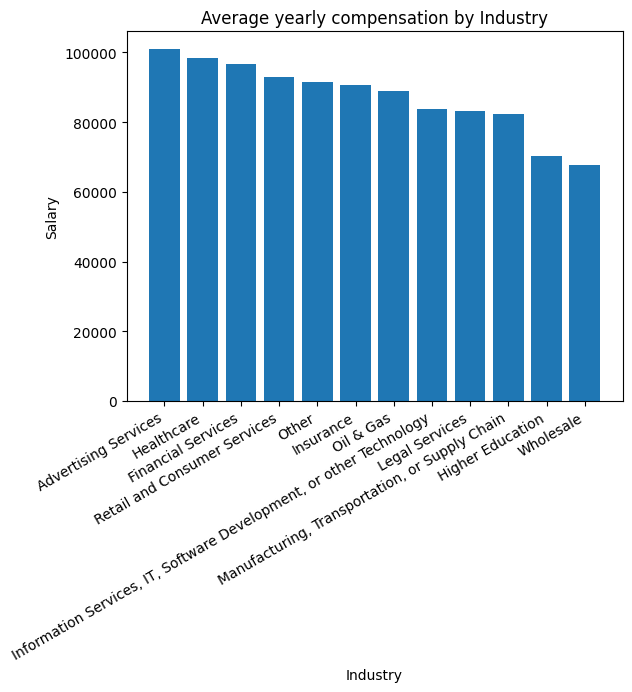

In [114]:
q_hi = df["ConvertedCompYearly"].quantile(0.99)
filtered_salaries = df[((df["ConvertedCompYearly"].isna() == False) & (df["ConvertedCompYearly"] > 0) & (df["ConvertedCompYearly"] < q_hi))] 
org_sizes = filtered_salaries.groupby(["Industry"])["ConvertedCompYearly"].mean()
org_sizes = org_sizes.sort_values(ascending=False)

fig, ax = plt.subplots()
ax.bar(org_sizes.index, org_sizes)
ax.set_title("Average yearly compensation by Industry")
ax.set_ylabel("Salary")
ax.set_xlabel("Industry")
plt.xticks(rotation=30, ha="right")